In [ ]:
# --- Cell 1: Environment & Imports ---
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Force TensorFlow Backend (Fixes Keras 3 errors)
os.environ["KERAS_BACKEND"] = "tensorflow"

# 2. Machine Learning Imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

# 3. Deep Learning Imports (Robust Aliasing)
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [10]:
# --- Cell 2: Data Pipeline ---

# 1. Load Data
df = pd.read_csv('smoker/train_dataset.csv')
print(f"Original Shape: {df.shape}")

# 2. Clean Duplicates
if df.duplicated().sum() > 0:
    print(f"Dropping {df.duplicated().sum()} duplicates...")
    df = df.drop_duplicates()

# 3. Feature Engineering
# BMI and Pulse Pressure
df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
df['Pulse_Pressure'] = df['systolic'] - df['relaxation']

# Drop redundant raw columns
df = df.drop(columns=['waist(cm)', 'systolic', 'relaxation'])

# 4. Log Transform Skewed Features
skewed_cols = ['Gtp', 'ALT', 'AST', 'triglyceride']
for col in skewed_cols:
    df[col] = np.log1p(df[col])

# 5. Split Data
X = df.drop('smoking', axis=1)
y = df['smoking']

# Stratified Split (Keeps class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Scale Features (Fit on Train, Transform Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Processed. X_train_scaled is ready.")

Original Shape: (38984, 23)
Dropping 5517 duplicates...
✅ Data Processed. X_train_scaled is ready.


Analyzing Feature Importance...


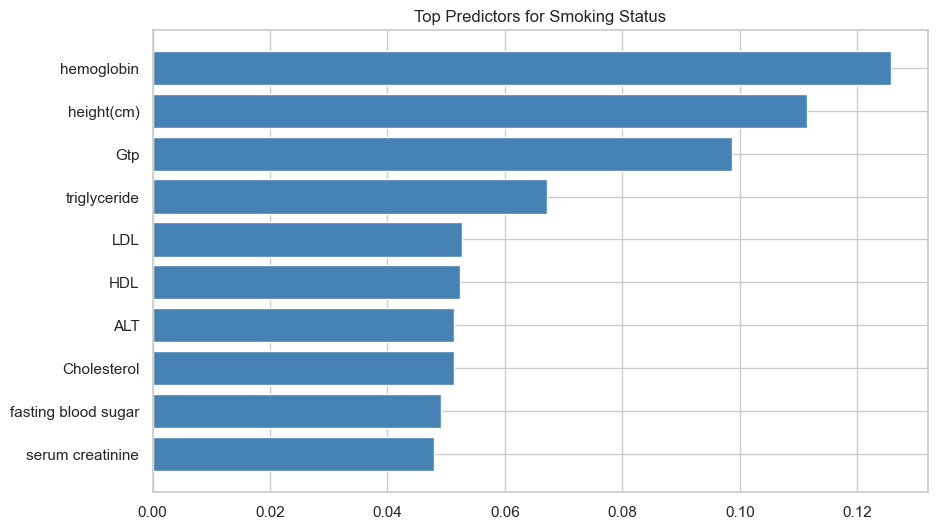

In [11]:
# --- Cell 3: Feature Importance ---
print("Analyzing Feature Importance...")

# Train quick Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# Plot
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.title("Top Predictors for Smoking Status")
plt.barh(range(10), importances[indices][:10], color='steelblue')
plt.yticks(range(10), [feature_names[i] for i in indices][:10])
plt.gca().invert_yaxis()
plt.show()

In [12]:
# --- Cell 4: Logistic Regression ---
print("Training Logistic Regression...")

# Balance Data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Grid Search
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=3000), 
    param_grid, cv=5, scoring='accuracy'
)
grid_lr.fit(X_train_smote, y_train_smote)

best_lr = grid_lr.best_estimator_
acc_lr = accuracy_score(y_test, best_lr.predict(X_test_scaled))

print(f"Best Params: {grid_lr.best_params_}")
print(f"LogReg Accuracy: {acc_lr:.4f}")

Training Logistic Regression...
Best Params: {'C': 10, 'solver': 'liblinear'}
LogReg Accuracy: 0.7257


In [13]:
# --- Cell 5: SVM ---
print("Training SVM (This may take ~1-2 mins)...")

# Randomized Search for speed
param_dist = {
    'C': [1, 10, 50], 
    'gamma': ['scale', 0.1], 
    'kernel': ['rbf']
}

rand_svm = RandomizedSearchCV(
    SVC(probability=True, class_weight='balanced'),
    param_dist, n_iter=5, cv=3, scoring='accuracy', random_state=42
)
rand_svm.fit(X_train_scaled, y_train)

best_svm = rand_svm.best_estimator_
acc_svm = accuracy_score(y_test, best_svm.predict(X_test_scaled))

print(f"Best SVM Params: {rand_svm.best_params_}")
print(f"SVM Accuracy: {acc_svm:.4f}")

Training SVM (This may take ~1-2 mins)...
Best SVM Params: {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}
SVM Accuracy: 0.7289


Training Neural Network...
Epoch 1/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7103 - loss: 0.5360 - val_accuracy: 0.6857 - val_loss: 0.6552 - learning_rate: 0.0010
Epoch 2/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7326 - loss: 0.5005 - val_accuracy: 0.7159 - val_loss: 0.6126 - learning_rate: 0.0010
Epoch 3/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7387 - loss: 0.4942 - val_accuracy: 0.6904 - val_loss: 0.6283 - learning_rate: 0.0010
Epoch 4/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7402 - loss: 0.4917 - val_accuracy: 0.7529 - val_loss: 0.5900 - learning_rate: 0.0010
Epoch 5/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7417 - loss: 0.4889 - val_accuracy: 0.7732 - val_loss: 0.5719 - learning_rate: 0.0010
Epoch 6/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7467 - loss: 0.4876 - val_accuracy: 0.7572 - val_loss: 0.5814 - learning_rate: 0.0010
Epoch 7/100
849/849 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - 

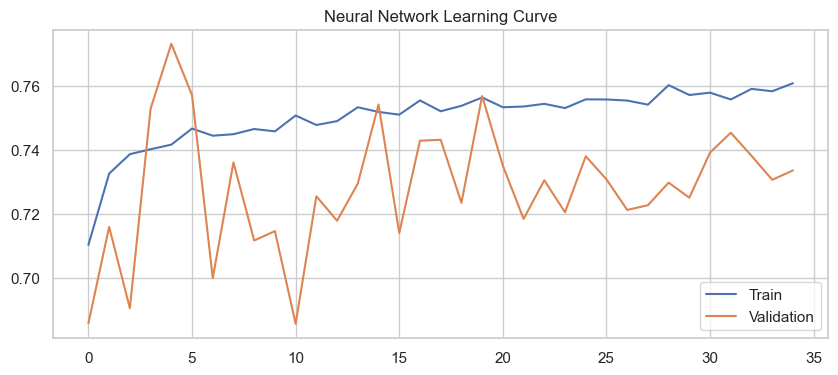

In [16]:
# --- Cell 6: Neural Network ---
print("Training Neural Network...")

# 1. Balance Data for NN
smote = SMOTE(random_state=42)
X_train_nn, y_train_nn = smote.fit_resample(X_train_scaled, y_train)

# 2. Build Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    
    Dense(1, activation='sigmoid')
])

# 3. Compile
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# 4. Callbacks (Auto-Tuning)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
]

# 5. Train
history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 6. Evaluate
loss, acc_nn = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Neural Network Accuracy: {acc_nn:.4f}")

# Plot History
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Neural Network Learning Curve")
plt.legend()
plt.show()

In [17]:
# --- Cell 7: Final Comparison ---
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'Neural Network'],
    'Accuracy': [acc_lr, acc_svm, acc_nn]
})
print(results.sort_values(by='Accuracy', ascending=False))

                 Model  Accuracy
2       Neural Network  0.756349
1                  SVM  0.728862
0  Logistic Regression  0.725725
